# Theano, Lasagne
and why they matter


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Warming up
* Implement a function that computes the sum of squares of numbers from 0 to N
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [341]:
import numpy as np
def sum_squares(N):
    return np.sum(np.arange(N)**2)

In [342]:
%%time
sum_squares(10**8)

CPU times: user 292 ms, sys: 712 ms, total: 1 s
Wall time: 1.01 s


662921401752298880

# theano teaser

Doing the very same thing

In [343]:
import theano
import theano.tensor as T

In [344]:
#I gonna be function parameter
N = T.scalar('a dimension', dtype='int32')

#i am a recipe on how to produce sum of squares of arange of N given N
result = (T.arange(N)**2).sum()

#Compiling the recipe of computing "result" given N
sum_function = theano.function(inputs = [N],outputs=result)

In [345]:
%%time
sum_function(10**8)

CPU times: user 276 ms, sys: 72 ms, total: 348 ms
Wall time: 350 ms


array(662921401752298880)

In [346]:
x = T.scalar()

f = theano.function([x], x / x)

In [347]:
f(0)

array(1.0)

# How does it work?
__if you're currently in classroom, chances are i am explaining this text wall right now__
* 1 You define inputs f your future function;
* 2 You write a recipe for some transformation of inputs;
* 3 You compile it;
* You have just got a function!
* The gobbledegooky version: you define a function as symbolic computation graph.


* There are two main kinds of entities: "Inputs" and "Transformations"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be integers, floats of booleans (uint8) of various size.


* An input is a placeholder for function parameters.
 * N from example above


* Transformations are the recipes for computing something given inputs and transformation
 * (T.arange(N)^2).sum() are 3 sequential transformations of N
 * Doubles all functions of numpy vector syntax
 * You can almost always go with replacing "np.function" with "T.function" aka "theano.tensor.function"
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * and so on.
   * builtin operations also work that way
   * np.arange(10).mean() -> T.arange(10).mean()
   * Once upon a blue moon the functions have different names or locations (e.g. T.extra_ops)
     * Ask us or google it
 
 
Still confused? We gonna fix that.

In [348]:
#Inputs
example_input_integer = T.scalar('scalar input', dtype='float32')

example_input_tensor = T.tensor4('four dimensional tensor input') #dtype = theano.config.floatX by default
#do not warry, we won't need tensor
#yet

input_vector = T.vector('', dtype='int32') # vector of integers

In [349]:
#Transformations

#transofrmation: elementwise multiplication
double_the_vector = input_vector * 2

#elementwise cosine
elementwise_cosine = T.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector

In [350]:
#Practice time:
#create two vectors of size float32
my_vector = T.vector('first vector', dtype='float32')
my_vector2 = T.vector('second vector', dtype='float32')

In [351]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = (my_vector*my_vector2) / (T.sin(my_vector) + 1)

In [352]:
print(my_transformation)
#it's okay it aint a number

Elemwise{true_div,no_inplace}.0


# Compiling
* So far we were using "symbolic" variables and transformations
 * Defining the recipe for computation, but not computing anything
* To use the recipe, one should compile it

In [353]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# The next lines compile a function that takes two vectors and computes your transformation
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
 )

In [354]:
#using function with, lists:
print('using python lists:')
print(my_function([1, 2, 3], [4, 5, 6]))
print()

#Or using numpy arrays:
#btw, that 'float' dtype is casted to secong parameter dtype which is float32
print('using numpy arrays:')
print(my_function(np.arange(10),
                  np.linspace(5, 6, 10, dtype='float')))

using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]

using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# Debugging
* Compilation can take a while for big functions
* To avoid waiting, one can evaluate transformations without compiling
* Without compilation, the code runs slower, so consider reducing input size


In [355]:
#a dictionary of inputs
my_function_inputs = {
    my_vector:[1, 2, 3],
    my_vector2:[4, 5, 6]
}

# evaluate my_transformation
# has to match with compiled function output
print(my_transformation.eval(my_function_inputs))


# can compute transformations on the fly
print('add 2 vectors', (my_vector + my_vector2).eval(my_function_inputs))


#!WARNING! if your transformation only depends on some inputs,
#do not provide the rest of them
print('vector\'s shape:', my_vector.shape.eval({
                            my_vector: [1, 2, 3]
                          })
     )

[  2.1721766    5.23752832  15.77397728]
add 2 vectors [ 5.  7.  9.]
vector's shape: [3]


* When debugging, one would generally want to reduce the computation complexity. For example, if you are about to feed neural network with 1000 samples batch, consider taking first 2.
* If you really want to debug graph of high computation complexity, you could just as well compile it (e.g. with optimizer='fast_compile')

# Do It Yourself

In [356]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

vec1 = T.vector('first vector', dtype='float64')
vec2 = T.vector('second vector', dtype='float64')

mse = T.mean((vec1 - vec2)**2)

compute_mse = theano.function(inputs=[vec1, vec2], outputs=mse, allow_input_downcast=True)

In [357]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            
            if not np.allclose(true_mse, my_mse):
                print('Wrong result:')
                print('mse({},{})'.format(el, el_2))
                print('should be: {}, but your function returned {}'.format(true_mse, my_mse))
                raise ValueError('Smth went wrong')

print('All tests passed')

All tests passed


# Shared variables

* The inputs and transformations only exist when function is called

* Shared variables always stay in memory like global variables
 * Shared variables can be included into a symbolic graph
 * They can be set and evaluated using special methods
   * but they can't change value arbitrarily during symbolic graph computation
   * we'll cover that later;
 
 
* Hint: such variables are a perfect place to store network parameters
 * e.g. weights or some metadata

In [358]:
#creating shared variable
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [359]:
#evaluating shared variable (outside symbolicd graph)
print('initial value', shared_vector_1.get_value())

# within symbolic graph you use them just as any other input or transformation, not "get value" needed

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [360]:
#setting new value
shared_vector_1.set_value( np.arange(5) )

#getting that new value
print('new value', shared_vector_1.get_value())

#Note that the vector changed shape
#This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

new value [ 0.  1.  2.  3.  4.]


# Your turn

In [361]:
# Write a recipe (transformation) that computes an elementwise transformation of shared_vector and input_scalar
#Compile as a function of input_scalar

input_scalar = T.scalar('coefficient', dtype='float32')

scalar_times_shared = shared_vector_1 * input_scalar

shared_times_n = theano.function(inputs = [input_scalar], outputs = scalar_times_shared)

In [362]:
print('shared:', shared_vector_1.get_value())

print('shared_times_n(5)', shared_times_n(5))

print('shared_times_n(-0.5)', shared_times_n(-0.5))

shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [363]:
#Changing value of vector 1 (output should change)
shared_vector_1.set_value([-1, 0, 1])

print('shared:', shared_vector_1.get_value())

print('shared_times_n(5)', shared_times_n(5))

print('shared_times_n(-0.5)', shared_times_n(-0.5))

shared: [-1.  0.  1.]
shared_times_n(5) [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad - why theano matters
* Theano can compute derivatives and gradients automatically
* Derivatives are computed symbolically, not numerically

Limitations:
* You can only compute a gradient of a __scalar__ transformation over one or several scalar or vector (or tensor) transformations or inputs.
* A transformation has to have float32 or float64 dtype throughout the whole computation graph
 * derivative over an integer has no mathematical sense


In [364]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#a derivative of v_squared by my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar], scalar_squared)
grad = theano.function([my_scalar], derivative) 

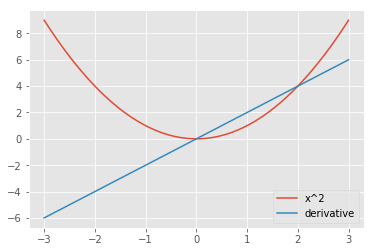

In [365]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

x = np.linspace(-3, 3)
x_squared = list(map(fun, x))
x_squared_der = list(map(grad, x))

plt.plot(x, x_squared, label='x^2')
plt.plot(x, x_squared_der, label='derivative')
plt.legend(loc='best')

# Why that rocks

In [366]:
my_vector = T.vector('float64')

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) + 1. / T.arcsinh(my_scalar)).mean() / (my_scalar**2 + 1) + 0.01 * T.sin(2 * my_scalar**1.5) * (T.sum(my_vector) * my_scalar**2) * T.exp((my_scalar - 4)**2) / (1 + T.exp((my_scalar - 4)**2)) * (1. - (T.exp( - (my_scalar - 4)**2)) / (1 + T.exp( - (my_scalar - 4)**2)))**2

der_by_scalar, der_by_vector = (T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector))

compute_weird_function = theano.function([my_scalar, my_vector], weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar, my_vector], der_by_scalar)

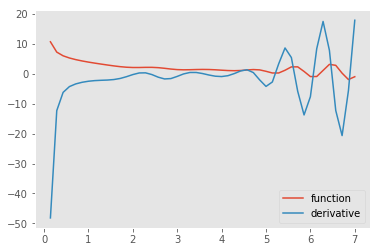

In [367]:
#Plotting your derivative
vector_0 = [1, 2, 3]

scalar_space = np.linspace(0, 7)

y = [compute_weird_function(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y, label='function')
y_der_by_scalar = [compute_der_by_scalar(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend(loc='best')

# Almost done - Updates

* updates are a way of changing shared variables at after function call.

* technically it's a dictionary {shared_variable : a recipe for new value} which is has to be provided when function is compiled

That's how it works:

In [368]:
# Multiply shared vector by a number and save the product back into shared vector

inputs = [input_scalar]
outputs = [scalar_times_shared] #return vector times scalar

my_updates = {
    shared_vector_1:scalar_times_shared #and write this same result bach into shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [369]:
shared_vector_1.set_value(np.arange(5))

#initial shared_vector_1
print('initial shared value:', shared_vector_1.get_value())

# evaluating the function (shared_vector_1 will be changed)
print('compute_and_save(2) returns', compute_and_save(2))

#evaluate new shared_vector_1
print('new shared value:', shared_vector_1.get_value())

initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Logistic regression example

Implement the regular logistic regression training algorithm

Tips:
* Weights fit in as a shared variable
* X and y are potential inputs
* Compile 2 functions:
 * train_function(X, y) - returns error and computes weights' new values __(through updates)__
 * predict_fun(X) - just computes probabilities ("y") given data
 
 
We shall train on a two-class MNIST dataset
* please note that target y are {0,1} and not {-1,1} as in some formulae

In [376]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X = mnist.data
y = mnist.target

print('y [shape - {}]:{}'.format(str(y.shape), y[:10]))
print('X [shape - {}]:'.format(str(X.shape)))
print(X[:3])
print(y[:10])

y [shape - (360,)]:[0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10.  

In [400]:
# inputs and shareds
shared_weights = theano.shared(np.random.randn(64))
input_X = T.matrix('data matrix', dtype='float64')
input_y = T.vector('target vector', dtype='int64')

In [401]:
predicted_y = 1 / (1 + T.exp(-T.dot(input_X, shared_weights)))

loss = -T.mean(input_y * T.log(predicted_y + 1e-6) + (1 - input_y) * T.log(1 - predicted_y + 1e-6))

grad = T.grad(loss, shared_weights)


updates = {
    shared_weights: (shared_weights - 0.01 * grad)
}

In [402]:
train_function = theano.function(inputs=[input_X, input_y], outputs=loss, updates=updates)
predict_function = theano.function(inputs=[input_X], outputs=predicted_y)

In [403]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

loss at iter 0:0.9936037562260249
train auc: 0.974203296703
test auc: 0.977226720648
loss at iter 1:0.705515497210146
train auc: 0.976758241758
test auc: 0.97975708502
loss at iter 2:0.5893042766331161
train auc: 0.978956043956
test auc: 0.982287449393
loss at iter 3:0.5302420091746906
train auc: 0.980549450549
test auc: 0.986842105263
loss at iter 4:0.4897027339851321
train auc: 0.981648351648
test auc: 0.987854251012
loss at iter 5:0.4590675624244633
train auc: 0.982527472527
test auc: 0.988360323887
loss at iter 6:0.4346041581164429
train auc: 0.983681318681
test auc: 0.98987854251
loss at iter 7:0.41397740507921443
train auc: 0.984642857143
test auc: 0.990384615385
loss at iter 8:0.395928643277645
train auc: 0.985247252747
test auc: 0.992914979757
loss at iter 9:0.3797649187692142
train auc: 0.985741758242
test auc: 0.993421052632
loss at iter 10:0.3650236455173591
train auc: 0.986263736264
test auc: 0.993421052632
loss at iter 11:0.3513772737575051
train auc: 0.986895604396
test a

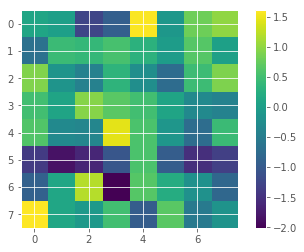

In [404]:
from sklearn.metrics import roc_auc_score

for i in range(100):
    loss_i = train_function(X_train, y_train)
    print('loss at iter {}:{}'.format(i, loss_i))
    print('train auc:', roc_auc_score(y_train,predict_function(X_train)))
    print('test auc:', roc_auc_score(y_test,predict_function(X_test)))
    
print('resulting weights:')
          
plt.imshow(shared_weights.get_value().reshape(8, -1))
plt.colorbar()

In [405]:
print(shared_weights.get_value())

[ 0.12078024  0.03127902 -1.25201343 -0.9081425   1.58930403 -0.09673391
  0.81309448  1.01135622 -0.65566898  0.45546257  0.40078773  0.55832868
  0.30817539 -0.01668518  0.65924494  0.04319298  0.91946475 -0.1361968
 -0.41704275  0.3475778  -0.2232394  -0.7330713   0.4756723   0.91198884
  0.5137783   0.10089647  0.94508557  0.67936297  0.51665936  0.10548237
 -0.29399128 -0.40793424  0.62065804 -0.2996478  -0.34605059  1.46116746
  0.5784256  -0.10200419 -0.72233043  0.45196945 -1.37799768 -1.83721339
 -1.62486141 -1.03902909  0.57662232 -0.94714918 -1.52387334 -1.32543978
 -0.8806589   0.13508312  1.20388477 -2.00831795  0.6549023   0.23670414
 -0.1836446  -0.79689742  1.60668712  0.12579604 -0.05902181  0.51321846
 -0.93604278  0.68234851 -0.51199369 -0.15422695]


# Report

I did such and such, that did that cool thing and my awesome logistic regression bloated out that stuff. Finally, i did that thing and felt like Einstein. That cool article and that kind of weed helped me so much (if any).

I struggled for one hour trying to combine two tensor functions (already compiled). I had defined and compiled a function called sigmoid, and I was trying to use it for predicted_y, then I realized that I don't need such things.
Then after I got rid of errors, gradient descent started to converge in 5 steps, I found it hard to believe so I tried to find a bug and spent ~2 hours testing everything. It turned out that I actually had done something wrong
I found Theano's documentation helpful.


P.S. no plants were harmed in the making of this notebook












# SPOILERS!

## Recommended pipeline
* Adapt logistic regression to classify some number against others (e.g. zero vs nonzero)
    * Generalize it to multiclass logistic regression.
* Instead of weight vector you'll have to use matrix (feature_id x class_id)
* softmax (exp over sum of exps) can be implemented manually or as T.nnet.softmax (stable)
* probably better to use STOCHASTIC gradient descent (minibatch)
     in which case sample should probably be shuffled (or use random subsamples on each iteration)